<h1><center>TME 09 </center></h1> <h1> <center> Bayesian Networks for Clinical Data Analysis

# Library importation

In [31]:
import pandas
import numpy
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.bn2graph as bnPlot
import pyAgrum.lib.dynamicBN as gdyn
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt
import os
import pandas as pd

1. Creating a network using PyAgrum. We would like to model the problem of type 2
diabetes remission after a gastric by-pass surgery which can be represented by the following
graph (note, that the problem is simplified extremely!):

In [2]:
bn=gum.BayesNet('WaterSprinkler')
print(bn)

BN{nodes: 0, arcs: 0, domainSize: 1, dim: 0}


In [3]:
Glycemia=bn.add(gum.LabelizedVariable('Glycemia','cloudy ?',2))
print(Glycemia)

0


In [4]:
Insuline, Other_drugs, Remission = [ bn.add(name, 2) for name in ["Insuline","Other_drugs","Remission"] ] #bn.add(name, 2) === bn.add(gum.LabelizedVariable(name, name, 2))
print (Insuline,Other_drugs,Remission)
print (bn)

1 2 3
BN{nodes: 4, arcs: 0, domainSize: 16, dim: 8}


In [5]:
bn.addArc(Glycemia,Insuline)

for link in [(Glycemia,Other_drugs),(Insuline,Remission),(Other_drugs,Remission)]:
    bn.addArc(*link)
print(bn)


BN{nodes: 4, arcs: 4, domainSize: 16, dim: 18}


In [6]:
bn

(gum::BayesNet<double>@0x7fd1c405c400) BN{nodes: 4, arcs: 4, domainSize: 16, dim: 18}

Yes = 0

No = 1

In [7]:
bn.cpt(Glycemia).fillWith([0.5,0.5])


(gum::Potential<double>@0x7fd1c5c06ee0) <Glycemia:0> :: 0.5 /<Glycemia:1> :: 0.5

In [8]:
bn.cpt(Insuline)[{ 'Glycemia': 0}] = [0.9, 0.1]
bn.cpt(Insuline)[{'Glycemia': 1}] = [0.1, 0.9]
bn.cpt(Insuline)

(gum::Potential<double>@0x7fd1c367bcd0) <Insuline:0|Glycemia:0> :: 0.9 /<Insuline:1|Glycemia:0> :: 0.1 /<Insuline:0|Glycemia:1> :: 0.1 /<Insuline:1|Glycemia:1> :: 0.9

In [9]:
bn.cpt(Other_drugs)[{ 'Glycemia': 0}] = [0.75, 0.25]
bn.cpt(Other_drugs)[{'Glycemia': 1}] = [0.3, 0.7]
bn.cpt(Other_drugs)

(gum::Potential<double>@0x7fd1c3642d60) <Other_drugs:0|Glycemia:0> :: 0.75 /<Other_drugs:1|Glycemia:0> :: 0.25 /<Other_drugs:0|Glycemia:1> :: 0.3 /<Other_drugs:1|Glycemia:1> :: 0.7

In [10]:
bn.cpt(Remission)[{'Insuline': 0, 'Other_drugs': 0}] = [0.1, 0.9]
bn.cpt(Remission)[{'Insuline': 1, 'Other_drugs': 0}] = [0.6, 0.4]
bn.cpt(Remission)[{'Insuline': 0, 'Other_drugs': 1}] = [0.3, 0.7]
bn.cpt(Remission)[{'Insuline': 1, 'Other_drugs': 1}] = [0.9, 0.1]
bn.cpt(Remission)

(gum::Potential<double>@0x7fd1c3645120) <Remission:0|Insuline:0|Other_drugs:0> :: 0.1 /<Remission:1|Insuline:0|Other_drugs:0> :: 0.9 /<Remission:0|Insuline:1|Other_drugs:0> :: 0.6 /<Remission:1|Insuline:1|Other_drugs:0> :: 0.4 /<Remission:0|Insuline:0|Other_drugs:1> :: 0.3 /<Remission:1|Insuline:0|Other_drugs:1> :: 0.7 /<Remission:0|Insuline:1|Other_drugs:1> :: 0.9 /<Remission:1|Insuline:1|Other_drugs:1> :: 0.1

In [11]:
ie=gum.LazyPropagation(bn)

If glycemia is less than 6.5 we are in the No categorie, so Glycemia = 1. No drugs taken = Other drugs to be false --> Other_drugs = 1

What is the probability to get the remission if the glycemia level is less than 6.5 and no drugs are taken?

In [12]:
ie.setEvidence({'Glycemia':1, 'Other_drugs': 1})
ie.makeInference()
ie.posterior(Remission)

(gum::Potential<double>@0x7fd1c36442d0) <Remission:0> :: 0.84 /<Remission:1> :: 0.16

What is the probability to get the remission if the glycemia level is bigger than 6.5 and insulin is prescribed?

In [13]:
ie.setEvidence({'Glycemia':0, 'Insuline': 0})
ie.makeInference()
ie.posterior(Remission)

(gum::Potential<double>@0x7fd1c35b1da0) <Remission:0> :: 0.15 /<Remission:1> :: 0.85

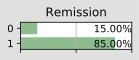

In [14]:
gnb.showProba(ie.posterior(Remission))

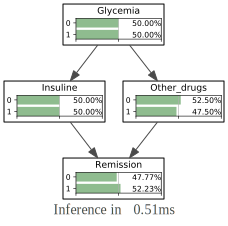

In [15]:
gnb.showInference(bn,evs={})


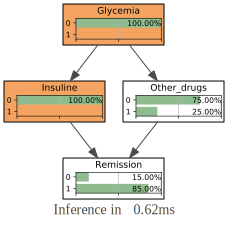

In [16]:
gnb.showInference(bn,evs={'Glycemia':0, 'Insuline': 0})


2. Construct Bayesian networks from real data. The data are in SPLEX env.txt and
SPLEX host.txt files. Construct one network for the environmental variables, one for the
host variables, and one with both environmental and host data.

## Load the data

In [17]:
data = pd.read_csv('dynamic.txt',sep=' ') # Observations
env = pd.read_csv('SPLEX_env.txt',sep=' ') # Observations
host=pd.read_csv('SPLEX_host.txt',sep=' ') # Observations


In [18]:
print(data)

     HbA1C0  HbA1C1  HbA1C2    Gly0  Gly1  Gly2  Poids0  Poids1  Poids2  \
0       6.7     5.9     6.1   6.105   4.7   5.0   110.7    67.0    72.0   
1       6.0     5.2     5.2   6.327   4.0   4.9   177.0   127.0   143.6   
2       6.8     5.9     6.6   7.881   6.0   6.4   133.4   110.0   115.0   
3       9.4     7.7     8.4  11.700   9.1   7.9    95.2    80.0    85.1   
4       8.0     5.7     5.9  10.700   5.4   5.6   120.0    92.1    84.7   
..      ...     ...     ...     ...   ...   ...     ...     ...     ...   
170     6.8     5.3     6.1   5.300   6.0   5.3   105.6    73.3    75.0   
171     7.6     5.5     7.9   4.500   4.7  10.6   146.7    96.4    88.8   
172     6.3     6.1     5.9   5.600   5.4   5.0   102.0    81.4    89.6   
173     5.9     6.3     6.3   5.500   5.4   7.7    90.5    73.0    78.0   
174     6.8     7.7     5.3   6.100   8.8   4.4   141.4    96.1    86.0   

     Status0  Status1  Status2  
0          1        1        3  
1          1        1        1  


In [19]:
print(env)

    cWI_ap  cSI_ap  cLI_ap  Food_intake_alim  Water_alim  Pr_alim  \
0       12       8       2                44          33       15   
1        1       7       1                18          37       43   
2        7      12      14                21          20       25   
3       11       2       7                23          43       28   
4       11      11       2                 3           1       45   
5       17       8      13                28          16       20   
6        4       7       8                43          10        9   
7        2       1       3                35           8       44   
8       14       9       1                43          10        9   
9       11       8       1                19          26       40   
10      13       8       1                22          34       30   
11      13       2       6                 1          29       12   
12      11       9       8                13          30       41   
13       5       2       1        

In [20]:
print(host)

    Sexe  Age  cBMI_corp  cTT_corp  cTH_corp     cWHR  cMGkg_corp  \
0      2   41   -0.93755       5.0      -1.0  0.05389       -2.53   
1      1   50   -2.54899      -9.0      -5.0 -0.04326       -2.69   
2      1   56   -1.23884       0.0       1.0 -0.00787        0.33   
3      1   34   -2.90913     -15.0      -6.0 -0.07791       -2.82   
4      1   56   -2.47137     -11.0      -4.0 -0.07015       -3.97   
5      1   60   -1.84604      -5.0      -7.0  0.00941       -3.95   
6      1   26   -1.76509     -17.0      -2.0 -0.12289       -6.15   
7      1   26   -2.94427     -10.0       0.0 -0.08772       -3.25   
8      2   34   -2.23798      -3.5      -3.5 -0.00214       -3.44   
9      1   41   -2.72857       9.0     -16.0  0.19380       -4.68   
10     2   35   -2.66892      -6.0      -3.0 -0.02419       -5.14   
11     1   31   -2.95331     -10.0      -8.0 -0.02961       -5.13   
12     1   33   -0.70517      -4.0      -2.0 -0.01987        0.00   
13     1   53   -1.52038      -5.0

In [21]:
l=[]
for col in env.columns.values:
    bins = numpy.linspace(min(env[col]), max(env[col]), 5)
    l.append(pd.DataFrame(numpy.digitize(env[col], bins),columns=[col]))
discr_data=pd.concat(l, join='outer', axis=1)
discr_data.to_csv("data/discr_data.csv",index=False)

In [22]:
learner=gum.BNLearner("data/discr_data.csv")
learner.useLocalSearchWithTabuList()
bn=learner.learnBN()

In [23]:
bn

(gum::BayesNet<double>@0x7fd1c5369200) BN{nodes: 63, arcs: 12, domainSize: 10^43.1935, dim: 771}

In [24]:
learner=gum.BNLearner("data/discr_data.csv")
learner.useGreedyHillClimbing()
bn=learner.learnBN()

In [25]:
bn

(gum::BayesNet<double>@0x7fd1c39e6000) BN{nodes: 63, arcs: 12, domainSize: 10^43.1935, dim: 771}

It's not the same graph. Actually the inference aren't based on the same methods. 

3. Dynamic Bayesian networks. Load data from dynamic.txt. In this file, you have HbA1C
(glycated hemoglobin), Gly (glycemia), Poids (weight of patients), and Status (remission,
non-remission, or partial remission) for time 0, 1 and 5 years after the surgery. Construct a
dynamic network to explore temporal dependencies in the data.

In [26]:
print(data)

     HbA1C0  HbA1C1  HbA1C2    Gly0  Gly1  Gly2  Poids0  Poids1  Poids2  \
0       6.7     5.9     6.1   6.105   4.7   5.0   110.7    67.0    72.0   
1       6.0     5.2     5.2   6.327   4.0   4.9   177.0   127.0   143.6   
2       6.8     5.9     6.6   7.881   6.0   6.4   133.4   110.0   115.0   
3       9.4     7.7     8.4  11.700   9.1   7.9    95.2    80.0    85.1   
4       8.0     5.7     5.9  10.700   5.4   5.6   120.0    92.1    84.7   
..      ...     ...     ...     ...   ...   ...     ...     ...     ...   
170     6.8     5.3     6.1   5.300   6.0   5.3   105.6    73.3    75.0   
171     7.6     5.5     7.9   4.500   4.7  10.6   146.7    96.4    88.8   
172     6.3     6.1     5.9   5.600   5.4   5.0   102.0    81.4    89.6   
173     5.9     6.3     6.3   5.500   5.4   7.7    90.5    73.0    78.0   
174     6.8     7.7     5.3   6.100   8.8   4.4   141.4    96.1    86.0   

     Status0  Status1  Status2  
0          1        1        3  
1          1        1        1  


In [27]:
l=[]
for col in env.columns.values:
    bins = numpy.linspace(min(env[col]), max(env[col]), 5)
    l.append(pd.DataFrame(numpy.digitize(env[col], bins),columns=[col]))
dataf=pd.concat(l, join='outer', axis=1)
dataf.to_csv("dynamic.csv",index=False)


In [28]:
learner=gum.BNLearner("dynamic.csv")
learner.useLocalSearchWithTabuList()
bn_dynamic=learner.learnBN()

In [29]:
bn_dynamic

(gum::BayesNet<double>@0x7fd1c3934800) BN{nodes: 63, arcs: 12, domainSize: 10^43.1935, dim: 771}

In [30]:
gdyn.showTimeSlices(bn_dynamic,'test.png')

Some variables aren't isolated such as Water_alim. Other are lineary organised, other have more complex connexions.